# Use W5E5 v2.0 and daily mass-balance (with MBsandbox)

**What is new?**
- `get_daily_mb` works with `run_with_hydro_daily` function of OGGM core and allows output of fluxes on daily timescale using daily mb

This has been tested for some glaciers in the Alps, Himalaya and Andes. It has also been tested against the output using monthly mb and annual mb. The behaviour seems to be reasonable.

`Melt_off_glacier` volumes are largest using annual mb and smallest using daily mb, for the `snow_bucket` this behaviour is reversed.

`residual_mb` is different for monthly mb and daily mb, but I think this is normal because the residual mb corrects the melt on glacier volumes to be consistent between annual/monthl/daily mb


For a run with real climate data starting in 1980, the volumes of the glacier are not close to the Farinotti estimate in 2004. I am not sure what the issue is?



> need to install MBsandbox: https://github.com/OGGM/massbalance-sandbox 


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, entity_task
from oggm.core import massbalance, flowline, climate
from oggm.utils import (floatyear_to_date, date_to_floatyear)

# just for the graphics
SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, process_era5_daily_data, TIModel, BASENAMES
# from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq
from MBsandbox.help_func import minimize_bias_geodetic, optimize_std_quot_brentq_geod, melt_f_calib_geod_prep_inversion
from MBsandbox.flowline_TIModel import (run_from_climate_data_TIModel,
                                        run_random_climate_TIModel)
cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = False

working_dir = utils.gettempdir(dirname='OGGM_hydro', reset=False)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

# as we calibrate to geodetic estimates we use calendar years!  
# need to check if this works in southern hemisphere
cfg.PARAMS['hydro_month_nh'] = 1


ALL_DIAGS = ['volume', 'volume_bsl', 'volume_bwl', 'area', 'length',
             'calving', 'calving_rate', 'off_area', 'on_area', 'melt_off_glacier',
             'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier',
             'snowfall_off_glacier', 'snowfall_on_glacier', 'model_mb',
             'residual_mb', 'snow_bucket']
cfg.PARAMS['store_diagnostic_variables'] = ALL_DIAGS


# get the geodetic calibration data
pd_geodetic = utils.get_geodetic_mb_dataframe()
pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']


2021-07-16 12:01:22: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-07-16 12:01:22: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-07-16 12:01:22: oggm.cfg: Multiprocessing: using all available processors (N=16)
2021-07-16 12:01:22: oggm.cfg: Multiprocessing switched ON after user settings.
2021-07-16 12:01:22: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2021-07-16 12:01:22: oggm.cfg: PARAMS['store_diagnostic_variables'] changed from `['volume', 'volume_bsl', 'volume_bwl', 'area', 'length', 'calving', 'calving_rate', 'off_area', 'on_area', 'melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_off_glacier', 'snowfall_on_glacier']` to `['volume', 'volume_bsl', 'volume_bwl', 'area', 'length', 'calving', 'calving_rate', 'off_area', 'on_area', 'melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_off_glacier', 'snowfall_

In [2]:
tasks.run_with_hydro_daily

<function oggm.core.flowline.run_with_hydro_daily(gdir, run_task=None, ref_area_from_y0=False, Testing=False, **kwargs)>

###  1. Step: initialize glacier directories.

This has just to be done once for a region (basin). It is independent of climate, mb_type, prcp_factpr etc

In [3]:
df = ['RGI60-11.00890', 'RGI60-11.00897'] # list of glaciers -> can be longer ... 
# this has to be done just once for a region (basin) (independent of climate, mb_type, prcp-fac ... )
init = True
if init:
    gdirs = workflow.init_glacier_directories(df[1], from_prepro_level=2,
                                              prepro_border=160,
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
    #Computes the Flowline along the unglaciated downstream topography
    workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    # The bedshape obtained by fitting a parabola to the line’s normals. Also computes the downstream’s altitude.
    workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)
else:
    gdirs = workflow.init_glacier_directories(df[1])

2021-07-16 12:01:23: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-07-16 12:01:23: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-07-16 12:01:24: oggm.utils: /home/shanus/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_160/L2/RGI60-11/RGI60-11.00.tar verified successfully.
2021-07-16 12:01:24: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2021-07-16 12:01:24: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2021-07-16 12:01:25: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2021-07-16 12:01:25: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_bedshape


### 2. Step Change inputs

Before the calibration select the climate type, mb_type, lapse rate type, precipitation factor
types of applying the temperature gradient: `cte` (default, constant lapse rate, set to default_grad, same as in default OGGM) or `var_an_cycle` (varies spatially and over annual cycle, but constant over the years)

mb_type can be either `mb_real_daily` or `mb_monthly` to either use daily mass balance or monthly mass balance

In [4]:
# if you have a precipitation factor from the hydrological model you can change it here
pf = 2  # precipitation factor ???????????????????????????????
climate_type = 'W5E5' # 'WFDE5_CRU'
#climate_type='WFDE5_CRU' -> need to use other pf and temp_bias ... 
mb_type = 'mb_real_daily' #real daily input, this would be monthly input:'mb_monthly' #'mb_real_daily' # 'mb_monthly'#
grad_type ='var_an_cycle' # variable lapse rates can also be 'cte' or 'var'



### 3. Step: melt_f calibration and inversion with glen-a calibration

In [5]:
# this has to be done once for each climate, mb_type, grad_type, pf option,
# then you can save the melt_f and a-factor for the runs later on 
#that is very helpful because then you could give different options for hte user but already have it calibrated

if climate_type =='W5E5':
    ye=2020 # till end of 2019
else:
    ye=2019
calib=True
if calib:

    if mb_type == 'mb_real_daily':
        temporal_resol = 'daily'
    else:
        temporal_resol = 'monthly'
        
    # get the climate data (either w5e5 or WFDE5_CRU)
    #function to get W5E5 data
    workflow.execute_entity_task(process_w5e5_data, gdirs,
                                 temporal_resol=temporal_resol, climate_type=climate_type)
 
    # calibrate melt_f and get apparent mb
    #calibrates melt_f to geodetic measurements
    loop = True
    if loop:
        for gdir in gdirs:
            melt_f_calib_geod_prep_inversion(gdir,
                                  pf = pf, # precipitation factor
                                 mb_type=mb_type, grad_type=grad_type,
                                 climate_type=climate_type, residual=0,
                                 path_geodetic=path_geodetic, ye=ye)
    else:
    # normally the workflow below, but at the moment it does not want to work ...
        workflow.execute_entity_task(melt_f_calib_geod_prep_inversion, gdirs, 
                                  pf = pf, # precipitation factor
                                 mb_type=mb_type, grad_type=grad_type,
                                 climate_type=climate_type, residual=0,
                                 path_geodetic=path_geodetic, ye=ye)

    # here glen-a is calibrated to mathch gdirs glaciers in total
    border = 80
    filter = border >= 20
    pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus(gdirs,
                                                          apply_fs_on_mismatch=False,ignore_missing=False,
                                                          error_on_mismatch=True,
                                                          filter_inversion_output=filter)
    #so for init_present_time_glacier, automatically the new glen a and melt f are used
    workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)


    a_factor = gdirs[0].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'] 
    # just a check if a-factor is set to the same value
    #you mean check if a-factor is the same for all glaciers in the region?
    np.testing.assert_allclose(a_factor, gdirs[-1].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'])


    # double check: volume sum of gdirs from Farinotti estimate is equal to oggm estimates
    # so estimates by Farinotti exist for each glacier individually?
    np.testing.assert_allclose(pd_inv_melt_f.sum()['vol_itmix_m3'], pd_inv_melt_f.sum()['vol_oggm_m3'], rtol = 1e-2)
    
    # we use the json now and don't need a csv file 
    # old!
    #pd_inv_melt_f['melt_f_opt']= pd_inv_melt_f.index.map(melt_f_dict)  # different for each glacier
    #pd_inv_melt_f['pf'] = pf #  everywhere the same
    #pd_inv_melt_f.to_csv('test_calib_params_{}_{}_{}.csv'.format(climate_type, mb_type, grad_type))

2021-07-16 12:01:26: oggm.workflow: Execute entity task process_w5e5_data on 1 glaciers
2021-07-16 12:01:26: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_w5e5_data
2021-07-16 12:01:26: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc
2021-07-16 12:01:26: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019.nc
2021-07-16 12:01:26: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_glacier_invariant_flat.nc
2021-07-16 12:01:28: oggm.utils: /home/shanus/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_lapserates_monthly.nc verified successfully.
2021-07-16 12:01:29: MBsandbox.help_func: (RGI60-11.00897) melt_f_calib_geod_prep_inversion
2021-07-16 12:01:30: oggm.core.climate: (RGI60-11.00897) apparent_mb_

#### like that we can access the calibrated melt_f (and prcp-fac)

In [6]:
fs = '_{}_{}_{}'.format(climate_type, mb_type, grad_type)
gdir = gdirs[-1]
print(gdir.read_json(filename='melt_f_geod', filesuffix=fs))
gdir = gdirs[0]
gdir.read_json(filename='melt_f_geod', filesuffix=fs)
#which dimension has the melt factor? -> kg/K/month? what should be the range of melt factors?

{'melt_f_pf_2': 193.66970106670712}


{'melt_f_pf_2': 193.66970106670712}

###  just look at volume changes starting from rgi_date

2021-07-16 12:01:30: oggm.workflow: Execute entity task run_from_climate_data_TIModel on 1 glaciers
2021-07-16 12:01:30: MBsandbox.flowline_TIModel: (RGI60-11.00897) run_from_climate_data_TIModel_W5E5_mb_real_daily_var_an_cycle
2021-07-16 12:01:30: oggm.core.flowline: (RGI60-11.00897) flowline_model_run_W5E5_mb_real_daily_var_an_cycle
2021-07-16 12:01:30: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-07-16 12:01:30: oggm.utils: Applying compile_run_output on 1 gdirs.


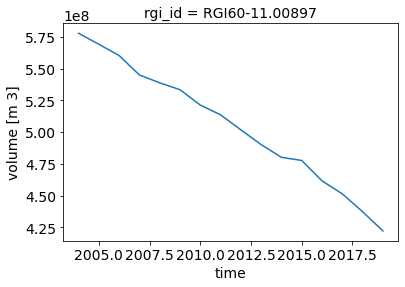

In [7]:
y0=2004
ye_h = ye-1   
# inside of run_from_climate_data_TIModel the calibrated melt_f is chosen from the melt_f_file csv file, such as:
# melt_f = pd_inv_melt_f['melt_f_opt'].loc[gdir.rgi_id]
# assert np.all(pf==pd_inv_melt_f['pf'])
workflow.execute_entity_task(run_from_climate_data_TIModel, gdirs, bias=0, #will actually point to the residual, should always be zero! 
                                  mb_model_class=TIModel,
                                  min_ys=y0, ye=ye_h,
                                  mb_type=mb_type,
                                  grad_type=grad_type,
                                  precipitation_factor=pf, 
                                  melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                                  climate_input_filesuffix=climate_type,
                                  output_filesuffix='_{}_{}_{}'.format(climate_type, mb_type, grad_type) # can add here more options to distinguish between runs
                                 )
ds_vol = utils.compile_run_output(gdirs, input_filesuffix='_{}_{}_{}'.format(climate_type, mb_type, grad_type))
ds_vol.sel(rgi_id=df[-1]).volume.plot()
# without hydro here

### 4. Step: Run with hydro daily function

Use the run with hydro daily function to run climate model with daily input data and daily output data.

In [8]:
# ds = ds_runoff.sel(rgi_id=df[-1])
#runs run_with_hydro with Lili's temperature index model
workflow.execute_entity_task(tasks.run_with_hydro_daily, gdirs,
                             run_task=run_random_climate_TIModel,
                             Testing = True,
                             nyears=100,
                             temperature_bias=0,
                             y0=2014, # if WFDE5_CRU need to set y0=2013 because no data for 2019
                             halfsize=5, seed=0, 
                             unique_samples=True,
                             store_monthly_step=False,
                             mb_elev_feedback='annual',
                             output_filesuffix='_new',
                             bias=0,  # only tested with bias=0 !!!, don't change!
                             mb_type=mb_type,
                             grad_type=grad_type,
                             precipitation_factor=pf, 
                             melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                             climate_input_filesuffix=climate_type,
                             )

ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_new')
#could also use with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
# but the method above aggregates all glaciers

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()

2021-07-16 12:01:30: oggm.workflow: Execute entity task run_with_hydro_daily on 1 glaciers
2021-07-16 12:01:30: MBsandbox.flowline_TIModel: (RGI60-11.00897) run_random_climate_TIModel_new
2021-07-16 12:01:30: oggm.core.flowline: (RGI60-11.00897) flowline_model_run_new
/mnt/c/Users/shanus/OGGM_Framework/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:1666: UserWarning: be cautiuous when using get_daily_mb and test yourself if it does what you expect
  warnings.warn('be cautiuous when using get_daily_mb and test yourself if it does '


(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 366) (152, 366)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 366) (152, 366)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 366) (152, 366)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 366) (152, 366)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 366) (152, 366)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 366) (152, 366)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 366) (152, 366)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 366) (152, 366)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365)

2021-07-16 12:01:32: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-07-16 12:01:32: oggm.utils: Applying compile_run_output on 1 gdirs.


(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)
(152, 365) (152, 365)


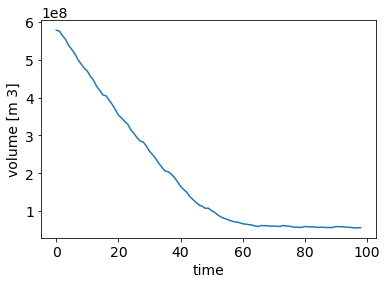

In [9]:
ds.volume.plot()

#### make a dataframe with yearly values and mean daily values

The mean daily values are a bit tricky because the length of the each year is 366 despite the fact that  only leap years are 366 days long. For non-lep years the values of the last day are set to 0.

In [10]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_new')) as ds:
    sel_vars = [v for v in ds.variables if 'day_2d' not in ds[v].dims]
    odf_m = ds[sel_vars].to_dataframe()
    sel_vars = [v for v in ds.variables if 'day_2d' in ds[v].dims]
    #odf_ma is mean monthly values over timeperiod
    odf_ma = ds[sel_vars].mean(dim='time').to_dataframe()
    odf_ma.columns = [c.replace('_day', '') for c in odf_ma.columns]

#### plot yearly runoff values

compared to the same run with monthly mb much less melt off glacier.

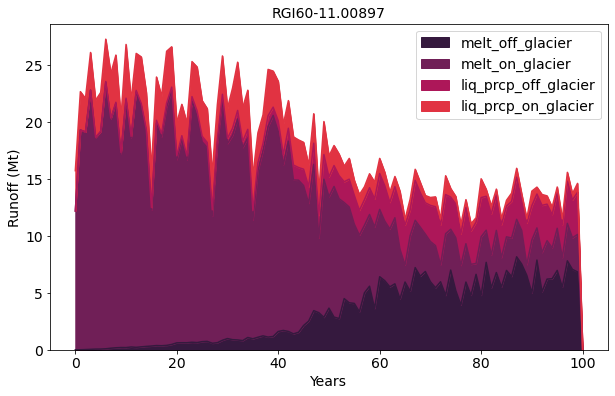

In [11]:
sel_vars = [v for v in ds.variables if 'day_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); #, stacked=False
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(gdir.rgi_id);

#### plot days with melt in the years

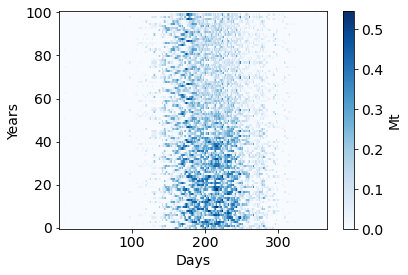

In [12]:
ds_roll = ds.roll(day_2d=ds['calendar_day_2d'].data[0]-1, roll_coords=True)
ds_roll['day_2d'] = ds_roll['calendar_day_2d']

# Select only the runoff variables and convert them to megatonnes (instead of kg)
monthly_runoff = ds_roll['melt_off_glacier_daily'] + ds_roll['melt_on_glacier_daily'] + ds_roll['liq_prcp_off_glacier_daily'] + ds_roll['liq_prcp_on_glacier_daily'] 
monthly_runoff *= 1e-9
monthly_runoff.clip(0).plot(cmap='Blues', cbar_kwargs={'label':'Mt'}); plt.xlabel('Days'); plt.ylabel('Years');

In [13]:
ds_roll

<xarray.Dataset>
Dimensions:                     (day_2d: 366, time: 101)
Coordinates:
  * time                        (time) float64 0.0 1.0 2.0 ... 98.0 99.0 100.0
    hydro_year                  (time) int64 0 1 2 3 4 5 ... 95 96 97 98 99 100
    hydro_month                 (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    calendar_year               (time) int64 0 1 2 3 4 5 ... 95 96 97 98 99 100
    calendar_month              (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * day_2d                      (day_2d) int64 1 2 3 4 5 ... 362 363 364 365 366
    calendar_day_2d             (day_2d) int64 1 2 3 4 5 ... 362 363 364 365 366
Data variables: (12/26)
    volume_m3                   (time) float64 5.779e+08 5.756e+08 ... 5.599e+07
    volume_bsl_m3               (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volume_bwl_m3               (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area_m2                     (time) float64 8.036e+06 8.031e+06 ... 2.085e+06
    length_m                    (time) float64 5.6e+03 5.7e+03 ... 1e+03 1e+03
    calving_m3                  (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                          ...
    snowfall_on_glacier_daily   (time, day_2d) float64 0.0 1.394e+07 ... nan nan
    snow_bucket                 (time) float64 0.0 4.751e+05 ... 3.226e+09
    snow_bucket_daily           (time, day_2d) float64 0.0 0.0 ... 0.0 0.0
    model_mb                    (time) float64 -2.002e+09 -1.087e+10 ... nan
    residual_mb                 (time) float64 1.119e+07 3.22e+07 ... nan
    residual_mb_daily           (time, day_2d) float64 0.0 0.0 0.0 ... nan nan
Attributes:
    description:          OGGM model output
    oggm_version:         1.5.1.dev0+g66a1f62.d20210714
    calendar:             365-day no leap
    creation_date:        2021-07-16 10:01:30
    water_level:          0
    glen_a:               6.2523512839766276e-24
    fs:                   0
    mb_model_class:       MultipleFlowlineMassBalance_TIModel
    mb_model_hemisphere:  nh

#### Plot average daily melt volumes for the first 10 years of simulation and the last 10 years

In [14]:
# Pick the variables we need (the 2d ones)
sel_vars = [v for v in ds_roll.variables if 'day_2d' in ds_roll[v].dims]

# Pick the first decade and average it
df_d_s = ds_roll[sel_vars].isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
# Rename the columns for readability
df_d_s.columns = [c.replace('_daily', '') for c in df_d_s.columns]
# Because of floating point precision sometimes runoff can be slightly below zero, clip
df_d_s = df_d_s.clip(0)

# Same for end
df_d_e = ds_roll[sel_vars].isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
df_d_e.columns = [c.replace('_daily', '') for c in df_d_s.columns]
df_d_e = df_d_e.clip(0)

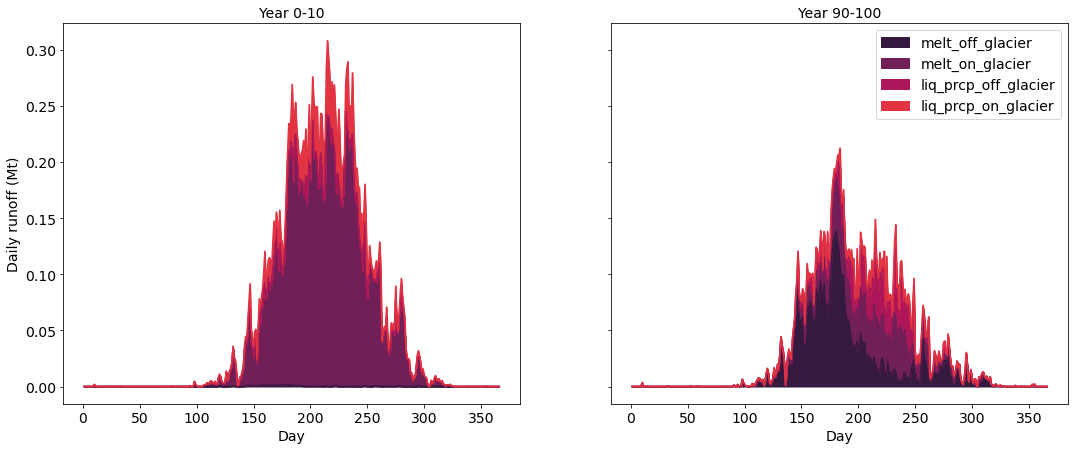

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
df_d_s[runoff_vars].plot.area(ax=ax1, legend=False, title='Year 0-10', color=sns.color_palette("rocket"));
df_d_e[runoff_vars].plot.area(ax=ax2, title='Year 90-100', color=sns.color_palette("rocket"));
ax1.set_ylabel('Daily runoff (Mt)'); ax1.set_xlabel('Day'); ax2.set_xlabel('Day');

#### get the monthly sum of the daily values and plot those

problem: for non leap years, values are shifted by one day to the front, so the result will not be totally correct, ut it is enough for a rough comparison

there is much less melt off glacier in years 90-100 than with monthly mb

In [16]:
df_d_s["Date"] = pd.date_range('2020-01-01', '2020-12-31', freq="D")
df_d_s.set_index('Date', inplace=True)
df_d_s.index = pd.to_datetime(df_d_s.index)

df_d_e["Date"] = pd.date_range('2020-01-01', '2020-12-31', freq="D")
df_d_e.set_index('Date', inplace=True)
df_d_e.index = pd.to_datetime(df_d_e.index)

In [17]:
df_m_s = df_d_s.resample("M").sum()
df_m_e = df_d_e.resample("M").sum()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
df_m_s[runoff_vars].plot.area(ax=ax1, legend=False, title='Year 0-10', color=sns.color_palette("rocket"));
df_m_e[runoff_vars].plot.area(ax=ax2, title='Year 90-100', color=sns.color_palette("rocket"));
ax1.set_ylabel('Monthly runoff (Mt)'); ax1.set_xlabel('Month'); ax2.set_xlabel('Month');

### 4. Step: Run with hydro daily function with real climate data

Use the run with hydro daily function to run climate model with daily input data and daily output data.

-----------------------------------------------------------------------------------
### Compare run_with_hydro_daily to outputs of run_with_hydro monthly, annual

In [ ]:
# daily mb
gdir = gdirs[-1]
# ds = ds_runoff.sel(rgi_id=df[-1])
#runs run_with_hydro with Lili's temperature index model
workflow.execute_entity_task(tasks.run_with_hydro_daily, gdirs,
                             run_task=run_random_climate_TIModel,
                             Testing = True,
                             nyears=100,
                             temperature_bias=0,
                             y0=2014, # if WFDE5_CRU need to set y0=2013 because no data for 2019
                             halfsize=5, seed=0, 
                             unique_samples=True,
                             store_monthly_step=False,
                             mb_elev_feedback='annual',
                             output_filesuffix='_new',
                             bias=0,  # only tested with bias=0 !!!, don't change!
                             mb_type=mb_type,
                             grad_type=grad_type,
                             precipitation_factor=pf, 
                             melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                             climate_input_filesuffix=climate_type,
                             )

ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_new')
#could also use with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
# but the method above aggregates all glaciers

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()

#all based on daily mb
#get annual values for all years
#get mean daily values
with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_new')) as ds:
    sel_vars = [v for v in ds.variables if 'day_2d' not in ds[v].dims]
    odf_annual_d_mb = ds[sel_vars].to_dataframe()
    sel_vars = [v for v in ds.variables if 'day_2d' in ds[v].dims]
    #odf_ma is mean monthly values over timeperiod
    #this gives wrong results with LEAP YEARS!!!
    odf_mean_daily_d_mb = ds[sel_vars].mean(dim='time').to_dataframe()
    odf_mean_daily_d_mb.columns = [c.replace('_daily', '') for c in odf_mean_daily_d_mb.columns]
    
#from mean daily values calculate mean monthly values
odf_mean_daily_d_mb["Date"] = pd.date_range('2020-01-01', '2020-12-31', freq="D")
odf_mean_daily_d_mb.set_index('Date', inplace=True)
odf_mean_daily_d_mb.index = pd.to_datetime(odf_mean_daily_d_mb.index)
odf_mean_monthly_d_mb = odf_mean_daily_d_mb.resample("M").sum()
#snow bucket is a state variable so NO sum
odf_mean_monthly_d_mb["snow_bucket"] = odf_mean_daily_d_mb["snow_bucket"].resample("M").mean()

In [ ]:
#monthly mb

workflow.execute_entity_task(tasks.run_with_hydro, gdirs,
                             run_task=run_random_climate_TIModel,
                             store_monthly_hydro=True,
                             nyears=100,
                             temperature_bias=0,
                             y0=2014, # if WFDE5_CRU need to set y0=2013 because no data for 2019
                             halfsize=5, seed=0, 
                             unique_samples=True,
                             store_monthly_step=False,
                             mb_elev_feedback='annual',
                             output_filesuffix='_monthly_mb',
                             bias=0,  # only tested with bias=0 !!!, don't change!
                             mb_type=mb_type,
                             grad_type=grad_type,
                             precipitation_factor=pf, 
                             melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                             climate_input_filesuffix=climate_type,
                             )
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_monthly_mb')
#could also use with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
# but the method above aggregates all glaciers

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()


#all based on daily mb
#get annual values for all years
#get mean monthly values
with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_monthly_mb')) as ds:
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    odf_annual_m_mb = ds[sel_vars].to_dataframe()
    sel_vars = [v for v in ds.variables if 'month_2d' in ds[v].dims]
    #odf_ma is mean monthly values over timeperiod
    odf_mean_monthly_m_mb = ds[sel_vars].mean(dim='time').to_dataframe()
    odf_mean_monthly_m_mb.columns = [c.replace('_monthly', '') for c in odf_mean_monthly_m_mb.columns]

In [ ]:
#annual mb

workflow.execute_entity_task(tasks.run_with_hydro, gdirs,
                             run_task=run_random_climate_TIModel,
                             store_monthly_hydro=False,
                             nyears=100,
                             temperature_bias=0,
                             y0=2014, # if WFDE5_CRU need to set y0=2013 because no data for 2019
                             halfsize=5, seed=0, 
                             unique_samples=True,
                             store_monthly_step=False,
                             mb_elev_feedback='annual',
                             output_filesuffix='_annual_mb',
                             bias=0,  # only tested with bias=0 !!!, don't change!
                             mb_type=mb_type,
                             grad_type=grad_type,
                             precipitation_factor=pf, 
                             melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                             climate_input_filesuffix=climate_type,
                             )
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_annual_mb')
#could also use with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
# but the method above aggregates all glaciers

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()


#all based on daily mb
#get annual values for all years
#get mean monthly values
with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_annual_mb')) as ds:
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    odf_annual_a_mb = ds[sel_vars].to_dataframe()

#### Check if annual input and melt volumes are the same for annual, monthly and daily mass balances

All variables but `melt_off_glacier`, `snow_bucket` and `residual_mb` are the same. `melt_off_glacier`, `snow_bucket` are more similar for daily and monthly mb.

`residual_mb` is very different between the different mb types
`residual_mb` is calculated by the current volume minus the previous volume, if residual mb is larger than the reconstructed mb melt on glacier is negative

In [ ]:
from numpy.testing import assert_allclose
# first compare annual values
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_on_glacier', 'snowfall_off_glacier',  'snow_bucket', 'residual_mb']
fig, axs = plt.subplots(len(runoff_vars), 1, figsize=(15,20))
for i, var in enumerate(runoff_vars):
    axs[i].plot(odf_annual_a_mb[var], label='annual mb')
    axs[i].plot(odf_annual_m_mb[var], label='monthly mb')
    axs[i].plot(odf_annual_d_mb[var], label='daily mb')
    axs[i].set_title(var)
    axs[i].legend()
    
    rtol = 1e-5
    if var == 'melt_off_glacier' or var == 'residual_mb':
        rtol = 0.8
        continue
    if var in ['snow_bucket']:
        continue
    print(var)
    print()
    assert_allclose(odf_annual_a_mb[var], odf_annual_m_mb[var], rtol=rtol)
    assert_allclose(odf_annual_d_mb[var], odf_annual_m_mb[var], rtol=rtol)
    assert_allclose(odf_annual_a_mb[var], odf_annual_d_mb[var], rtol=rtol)
    

#### Check if monthly input and melt volumes are the same for monthly and daily mass balances

All variables but `melt_off_glacier`, `snow_bucket` and `residual_mb` are the same. 

`snow_bucket` tend to be higher for daily mb and decrease earlier in the year for daily mb. This is maybe caused y different values of `melt_off_glacier` which reduces the values of the snow bucket??

For Fabruary comparison is more difficult because of different handling of leap years, so assertions are not made for February.

In [ ]:
from numpy.testing import assert_allclose
for c in odf_mean_monthly_m_mb.columns[1:]:
    rtol = 1e-5
    if c == 'melt_off_glacier' or c == 'residual_mb':
        #rtol = 0.15
        # quite different, up tp 50%!
        # but this is 'ok' as fabien said
        # run_with_hydro with annual update is just very different there
        if mb_type == 'mb_monthly':
            # why is it even worse for mb_monthly
            rtol = 1.1
        elif mb_type == 'mb_real_daily':
            # sum of daily solid prcp update
            rtol = 0.8 #0.5
    if c in ['snow_bucket']:
        continue
    #assertion is not made for February because differences are bigger
    assert_allclose(odf_mean_monthly_d_mb[c][2:], odf_mean_monthly_m_mb[c][2:], rtol=rtol)
    assert_allclose(odf_mean_monthly_d_mb[c].values[0], odf_mean_monthly_m_mb[c].values[0], rtol=rtol)
    assert (np.abs((odf_mean_monthly_d_mb[c].values[0] - odf_mean_monthly_m_mb[c].values[0])/ odf_mean_monthly_m_mb[c].values[0])) < rtol

In [ ]:
#second compare monthly values

runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_on_glacier', 'snowfall_off_glacier',  'snow_bucket', 'residual_mb']
fig, axs = plt.subplots(len(runoff_vars), 1, figsize=(15,25))
months = np.arange(1,13)
for i, var in enumerate(runoff_vars):
    axs[i].plot(months, odf_mean_monthly_m_mb[var], label='monthly mb')
    axs[i].plot(months, odf_mean_monthly_d_mb[var], label='daily mb')
    axs[i].set_title(var)
    axs[i].legend()

In [ ]:
#ssert mass balance closure for monthly mb on annual basis

from numpy.testing import assert_allclose
with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_monthly_mb')) as ds:
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    odf_m = ds[sel_vars].to_dataframe().iloc[:-1]


sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
odf_m = ds[sel_vars].to_dataframe().iloc[:-1]
odf_m['tot_prcp'] = (odf_m['liq_prcp_off_glacier'] +
                   odf_m['liq_prcp_on_glacier'] +
                   odf_m['snowfall_off_glacier'] +
                   odf_m['snowfall_on_glacier'])
odf_m['runoff'] = (odf_m['melt_on_glacier'] +
                 odf_m['melt_off_glacier'] +
                 odf_m['liq_prcp_on_glacier'] +
                 odf_m['liq_prcp_off_glacier'])
odf_m['melt_tot'] = (odf_m['melt_on_glacier'] +
                 odf_m['melt_off_glacier'])
odf_m['snowfall_tot'] = (odf_m['snowfall_off_glacier'] +
                   odf_m['snowfall_on_glacier'])
mass_in_snow = np.diff(odf_m['snow_bucket'])
mass_in = odf_m['tot_prcp'].iloc[:-1]
mass_out = odf_m['runoff'].iloc[:-1]
mass_in_glacier_end = odf_m['volume_m3'].iloc[1:] * cfg.PARAMS['ice_density'] #to get kg
mass_in_glacier_start = odf_m['volume_m3'].iloc[0:-1] * cfg.PARAMS['ice_density']
assert_allclose(mass_in_glacier_end,
                mass_in_glacier_start + mass_in - mass_out - mass_in_snow,
                atol=1e-2)

In [ ]:
#assert mass balance closure for daily mb on annual basis

from numpy.testing import assert_allclose
with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_new')) as ds:
    sel_vars = [v for v in ds.variables if 'day_2d' not in ds[v].dims]
    odf_d = ds[sel_vars].to_dataframe().iloc[:-1]


sel_vars = [v for v in ds.variables if 'day_2d' not in ds[v].dims]
odf_d = ds[sel_vars].to_dataframe().iloc[:-1]
odf_d['tot_prcp'] = (odf_d['liq_prcp_off_glacier'] +
                   odf_d['liq_prcp_on_glacier'] +
                   odf_d['snowfall_off_glacier'] +
                   odf_d['snowfall_on_glacier'])
odf_d['runoff'] = (odf_d['melt_on_glacier'] +
                 odf_d['melt_off_glacier'] +
                 odf_d['liq_prcp_on_glacier'] +
                 odf_d['liq_prcp_off_glacier'])
odf_d['melt_tot'] = (odf_d['melt_on_glacier'] +
                 odf_d['melt_off_glacier'])
odf_d['snowfall_tot'] = (odf_d['snowfall_off_glacier'] +
                   odf_d['snowfall_on_glacier'])
mass_in_snow = np.diff(odf_d['snow_bucket'])
mass_in = odf_d['tot_prcp'].iloc[:-1]
mass_out = odf_d['runoff'].iloc[:-1]
mass_in_glacier_end = odf_d['volume_m3'].iloc[1:] * cfg.PARAMS['ice_density'] #to get kg
mass_in_glacier_start = odf_d['volume_m3'].iloc[0:-1] * cfg.PARAMS['ice_density']
assert_allclose(mass_in_glacier_end,
                mass_in_glacier_start + mass_in - mass_out - mass_in_snow,
                atol=1e-2)

In [ ]:
#assert mass balance closure for annual mb

from numpy.testing import assert_allclose
with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_annual_mb')) as ds:
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    odf_a = ds[sel_vars].to_dataframe().iloc[:-1]


sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
odf_a = ds[sel_vars].to_dataframe().iloc[:-1]
odf_a['tot_prcp'] = (odf_a['liq_prcp_off_glacier'] +
                   odf_a['liq_prcp_on_glacier'] +
                   odf_a['snowfall_off_glacier'] +
                   odf_a['snowfall_on_glacier'])
odf_a['runoff'] = (odf_a['melt_on_glacier'] +
                 odf_a['melt_off_glacier'] +
                 odf_a['liq_prcp_on_glacier'] +
                 odf_a['liq_prcp_off_glacier'])
odf_a['melt_tot'] = (odf_a['melt_on_glacier'] +
                 odf_a['melt_off_glacier'])
odf_a['snowfall_tot'] = (odf_a['snowfall_off_glacier'] +
                   odf_a['snowfall_on_glacier'])
mass_in_snow = np.diff(odf_a['snow_bucket'])
mass_in = odf_a['tot_prcp'].iloc[:-1]
mass_out = odf_a['runoff'].iloc[:-1]
mass_in_glacier_end = odf_a['volume_m3'].iloc[1:] * cfg.PARAMS['ice_density'] #to get kg
mass_in_glacier_start = odf_a['volume_m3'].iloc[0:-1] * cfg.PARAMS['ice_density']
assert_allclose(mass_in_glacier_end,
                mass_in_glacier_start + mass_in - mass_out - mass_in_snow,
                atol=1e-2)

In [ ]:
runoff_vars = ['tot_prcp', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier',  'snowfall_off_glacier', 'snowfall_on_glacier', 'melt_on_glacier', 'volume_m3']
for i, var in enumerate(runoff_vars):
    assert_allclose(odf_a[var],odf_m[var], atol=1e-2)
    assert_allclose(odf_m[var],odf_d[var], atol=1e-2)

Total volumes of melt off glaciers are largest for annual mass balance and smallest for daily mass balance.
Water accumulated in snow bucket at the end of simulation is largest for daily mass balance and smallest for annual mass balance.

In [ ]:
print("Melt off glacier annual mb (10^9)", np.sum(odf_a['melt_off_glacier']) / 1000000000)
print("Melt off glacier monthly mb (10^9)", np.sum(odf_m['melt_off_glacier']) / 1000000000)
print("Melt off glacier daily mb (10^9)", np.sum(odf_d['melt_off_glacier']) / 1000000000)
print("Snow Bucket annual mb (10^9)", odf_a['snow_bucket'].values[-1] / 1000000000)
print("Snow Bucket monthly mb (10^9)", odf_m['snow_bucket'].values[-1] / 1000000000)
print("Snow Bucket daily mb (10^9)", odf_d['snow_bucket'].values[-1] / 1000000000)

### Run with real climate data
#### Check if monthly input and melt volumes are the same for monthly and daily mass balances

In [ ]:
def leap_year(y):
    if y % 400 == 0:
        return True
    if y % 100 == 0:
        return False
    if y % 4 == 0:
        return True
    else:
        return False

In [ ]:
#daily mb

ye = 2020
workflow.execute_entity_task(tasks.run_with_hydro_daily, gdirs, 
                             run_task=run_from_climate_data_TIModel,
                    Testing = True,
                    ys=1980, ye=2020,
                    store_monthly_step= False,
                    output_filesuffix='_daily_1980_{}_{}_{}'.format(ye, mb_type, grad_type),
                    # kwargs for TIModel 
                     mb_model_class=TIModel,
                     bias=0, # only tested with bias=0 !!!, don't change!
                     mb_type=mb_type,
                     grad_type=grad_type,
                     precipitation_factor=pf, melt_f='from_json',
                     climate_input_filesuffix=climate_type,
                    )
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_daily_1980_{}_{}_{}'.format(ye, mb_type, grad_type))
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()

# The last step of hydrological output is NaN (we can't compute it for this year)
ds = ds.isel(time=slice(0, -1)).load()
sel_vars = [v for v in ds.variables if 'day_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); #, stacked=False
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(gdir.rgi_id);

#all based on daily mb
#get annual values for all years
#get mean daily values
with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix = '_daily_1980_{}_{}_{}'.format(ye, mb_type, grad_type))) as ds:
    sel_vars = [v for v in ds.variables if 'day_2d' not in ds[v].dims]
    odf_annual_d_mb = ds[sel_vars].to_dataframe()
    sel_vars = [v for v in ds.variables if 'day_2d' in ds[v].dims]
    #odf_ma is mean monthly values over timeperiod
    odf_dailyd_mb = ds[sel_vars].mean(dim='time').to_dataframe()
    odf_mean_daily_d_mb = ds[sel_vars].mean(dim='time').to_dataframe()
    odf_mean_daily_d_mb.columns = [c.replace('_daily', '') for c in odf_mean_daily_d_mb.columns]
    
#from mean daily values calculate mean monthly values
odf_mean_daily_d_mb["Date"] = pd.date_range('2020-01-01', '2020-12-31', freq="D")
odf_mean_daily_d_mb.set_index('Date', inplace=True)
odf_mean_daily_d_mb.index = pd.to_datetime(odf_mean_daily_d_mb.index)
odf_mean_monthly_d_mb = odf_mean_daily_d_mb.resample("M").sum()
#snow bucket is a sate variable so NO sum
odf_mean_monthly_d_mb["snow_bucket"] = odf_mean_daily_d_mb["snow_bucket"].resample("M").mean()

#from mean daily values calculate mean monthly values under the assumption of no leap year
#odf_mean_daily_d_mb = odf_mean_daily_d_mb.iloc[:365,:]
#odf_mean_daily_d_mb["Date"] = pd.date_range('2019-01-01', '2019-12-31', freq="D")
#odf_mean_daily_d_mb.set_index('Date', inplace=True)
#odf_mean_daily_d_mb.index = pd.to_datetime(odf_mean_daily_d_mb.index)
#odf_mean_monthly_d_mb = odf_mean_daily_d_mb.resample("M").sum()
#snow bucket is a sate variable so NO sum
#odf_mean_monthly_d_mb["snow_bucket"] = odf_mean_daily_d_mb["snow_bucket"].resample("M").mean()

### Volumes to not match Fariontti estimate
The volume of the modelled glacier is close to the Farinotti estimate for the start of the simulation period but not for 2004. 
So the calibration is probably not that good?


In [ ]:
ds.volume_m3.plot()
ds.sel(time=2004).volume_m3
gdir = gdirs[0]
# volume estimate of Farinotti 
plt.plot(2004, pd_inv_melt_f.loc[gdir.rgi_id].vol_itmix_m3, 'o', label='Farinotti estimate')
plt.legend()

In [ ]:
timeseries_df = pd.DataFrame()
for var in sel_vars[2:]:
    for i,year in enumerate(ds.time.values):
        if not leap_year(year):
            last_day = 365
        else:
            last_day = 366
        if i == 0:
            values_all_years = ds[var][i].values[:last_day]
        else:
            values_all_years = np.concatenate((values_all_years, ds[var][i].values[:last_day]), axis = None)
            
    #make a column in dataframe
    timeseries_df[var] = values_all_years

#add a date
timeseries_df["Date"] = np.arange('1980-01-01', '2021-01-01', dtype='datetime64')   
timeseries_df.set_index('Date',inplace=True)

In [ ]:
#monthly mb

ye = 2020
workflow.execute_entity_task(tasks.run_with_hydro, gdirs, 
                             run_task=run_from_climate_data_TIModel, store_monthly_hydro= True,
                    ys=1980, ye=2020,
                    store_monthly_step= False,
                    output_filesuffix='_1980_{}_{}_{}'.format(ye, mb_type, grad_type),
                    # kwargs for TIModel 
                     mb_model_class=TIModel,
                     bias=0, # only tested with bias=0 !!!, don't change!
                     mb_type=mb_type,
                     grad_type=grad_type,
                     precipitation_factor=pf, melt_f='from_json',
                     climate_input_filesuffix=climate_type,
                    )

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()


#all based on daily mb
#get annual values for all years
#get mean monthly values
with xr.open_dataset(gdir.get_filepath('model_diagnostics',
                                       filesuffix='_1980_{}_{}_{}'.format(ye, mb_type, grad_type))) as ds:
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    odf_annual_m_mb = ds[sel_vars].to_dataframe()
    sel_vars = [v for v in ds.variables if 'month_2d' in ds[v].dims]
    #odf_ma is mean monthly values over timeperiod
    odf_mean_monthly_m_mb = ds[sel_vars].mean(dim='time').to_dataframe()
    odf_mean_monthly_m_mb.columns = [c.replace('_monthly', '') for c in odf_mean_monthly_m_mb.columns]

In [ ]:
from numpy.testing import assert_allclose
# first compare annual values
time = np.arange(1980,2021)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_on_glacier', 'snowfall_off_glacier',  'snow_bucket', 'residual_mb']
fig, axs = plt.subplots(len(runoff_vars), 1, figsize=(15,30))
for i, var in enumerate(runoff_vars):
    axs[i].plot(odf_annual_m_mb[var], label='monthly mb')
    axs[i].plot(odf_annual_d_mb[var], label='daily mb')
    axs[i].set_title(var)
    axs[i].legend()
    
    rtol = 1e-5
    if var == 'melt_off_glacier' or var == 'residual_mb':
        rtol = 0.5
        continue
    if var in ['snow_bucket']:
        continue
    #assert_allclose(odf_annual_a_mb[var], odf_annual_m_mb[var], rtol=rtol)
    #assert_allclose(odf_annual_d_mb[var], odf_annual_m_mb[var], rtol=rtol)

#### Check if monthly input and melt volumes are the same for monthly and daily mass balances

All variables but `melt_off_glacier`, `snow_bucket` and `residual_mb` are the same. 
Snow bucket seems kind of shifted for daily mb

For Fabruary comparison is more difficult because of different handling of leap years.

Handling of Leap Years:
daily mb: data array has 366 entires, for non-leap years the last day is given 0 values for fluxes and the same value as the day before for the state variable snow_bucket if `Testing = False` (default). If `Testing = True` for non leap years there are nan values for the 29th of February. So then each day in the array corresponds to the same day, no matter if its leap years or not.

For the comparison the daily values are averaged over the years and then the monthly mean is taken.

monthly mb: 
in OGGM the length of each year is assumed to be 365.25 years, and the second in a month are assumed such that each month in the year has the same length (365/12), therefore the values for February differ

In [ ]:
odf_mean_monthly_m_mb

In [ ]:
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_on_glacier', 'snowfall_off_glacier',  'snow_bucket', 'residual_mb']
fig, axs = plt.subplots(len(runoff_vars), 1, figsize=(15,30))
months = np.arange(1,13)
for i, var in enumerate(runoff_vars):
    axs[i].plot(months, odf_mean_monthly_m_mb[var], label='monthly mb')
    axs[i].plot(months, odf_mean_monthly_d_mb[var], label='daily mb')
    axs[i].set_title(var)
    axs[i].legend()

#### plot daily variables over the whole year

In [ ]:
# plot mean daily values in the year
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_on_glacier', 'snowfall_off_glacier',  'snow_bucket', 'residual_mb']
fig, axs = plt.subplots(len(runoff_vars), 1, figsize=(15,20))
for i, var in enumerate(runoff_vars):
    axs[i].plot(odf_mean_daily_d_mb[var])
    axs[i].set_title(var)

### Check if melt in year follows the temperature in the year

to visualize it easier the melt and temperature are normalized

the melt seems shifted by one day because melt always has 366 days whereas climate only has 366 days when there are leap years

In [ ]:
climate = xr.open_dataset('/tmp/OGGM/OGGM_hydro/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/climate_historical_daily_W5E5.nc')

In [ ]:
year = 12
real_year = int(ds_runoff.melt_on_glacier_daily[year,:,0].time.values)
print(leap_year(year))
    
runoff_one_year = ds_runoff.melt_on_glacier_daily[year,:,0]
normalize_melt = (runoff_one_year - np.min(runoff_one_year)) / (np.max(runoff_one_year) - np.min(runoff_one_year)) 
clim_80_19 = climate.temp[climate.time.isin(np.arange(str(real_year), str(real_year + 1), dtype='datetime64[D]'))]
normalize_climate = (clim_80_19 - np.min(clim_80_19)) / (np.max(clim_80_19) - np.min(clim_80_19))
plt.figure(figsize=(40,15))
plt.plot(clim_80_19 / 10, label="temperature / 10 ")
plt.plot(normalize_melt, label="normalized melt")
plt.legend()